## Curie depth estimation for the Transantarctic Mountains and Wilkes Subglacial Basin using the Tanaka approch within pycurious developed by Mather and Delhaye (2019).
### jupyter notebook written by Maximilian Lowe (maxwe32@bas.ac.uk). Last update 09/05/2022

This notebook reads the magnteic data, grids the data, devides the grid into subgrids (windows), calcualtes for each window the power spectrum, calcualtes the Curie depth point by fitting linear regression for predefined parts of the powersprectrum, applies topographic and geoid correction and calcualtes the GHF.


#### Import python modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pycurious
from pycurious import mapping

import cartopy.crs as ccrs
import cartopy.feature

import pandas as pd
import os

from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

## Download magnetic data and topographic data at: https://www.dropbox.com/sh/8h3nf438hdlpbs8/AADtjRvA-JANHrVsrA6pWlfma?dl=0

#### Load magnetic data

In [3]:
mag_data_pd = pd.read_csv('ADMAP_draped_4km_15_km_blanking.txt', skiprows=0, names=['x','y','ADMAP_4km'])

## Convert pd data fram to numpy arrays 
aeromag = mag_data_pd.to_numpy()

## Define data channels
x = aeromag[:,0]
y = aeromag[:,1]
z = aeromag[:,2]

#### Data overview

In [4]:
## Get data stats
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
zmin, zmax = z.min(), z.max()

## Print extent of the magnetic grid 
print("xmin", xmin, "[m]") 
print("xmax" , xmax , "[m]")
print("\nymin", ymin, "[m]") 
print("ymax" , ymax , "[m]")
print("\nmagnetic min", zmin, "[nT]") 
print("magnetic max" , zmax , "[nT]")

xmin -274896.32101388 [m]
xmax 1721603.67898612 [m]

ymin -2273606.2081065 [m]
ymax -752606.2081065 [m]

magnetic min -772.259765625 [nT]
magnetic max 2488.7666015625 [nT]


#### Define Variables for automated run

In [24]:
## define values for dynamic runs
window_size = 300e3
upward_cont = 4 # upward contiunued data to 4 km height


#### Grid magnetic data (can take long depending on how large the input dataset is)

In [25]:
## Prepare gridding

## define grid spacing
dx = 1500 # [m]
dy = 1500 # [m]

## Define the extent of the grid
extent_grid = (xmin,xmax,ymin,ymax)

## Estimate the grid points / the shape of the grid
ny = int((ymax-ymin)/dy)
nx = int((xmax-xmin)/dx)

## Grid the data
mag_grid = mapping.grid(np.c_[x,y], z, extent_grid, shape=(ny,nx))

grid = pycurious.CurieOptimiseTanaka(mag_grid, xmin, xmax, ymin, ymax)



###### fixed wavenumber range for automated run
z0: 0.006-0.033

zT: 0.04 – 0.2

In [26]:
## Define ranges for the low and high wavenumber part 
k_weighted_z0_min = 0.006
k_weighted_z0_max = 0.033

k_zT_min = 0.04
k_zT_max = 0.2


#### Prepare result variables and linear regression variables

In [27]:
## create empty object to save the results of the for loop for each iteration
output_CDP_estimate = np.zeros((len(xc_list),10))
ML_error = np.zeros((len(xc_list),5))


def linear_func(x, a, b):
    """ linear function to find values of a and b """
    return a*x+b

#### Looping over every window to calculate data coverage, CDP and uncertainty

In [28]:
## For loop calculating powerspectrum and curie depths for each window
for i in tqdm(range(len(xc_list))):
    
    # centroid index for export
    cp_ix = i+1  
    
    # get x and y centroid coordinates 
    xpt = xc_list[i]
    ypt = yc_list[i]
    
    # grid windowed data
    subgrid = grid.subgrid(window_size, xpt, ypt)
    
    # calcualte spectra
    k, Phi, sigma_Phi = grid.radial_spectrum(subgrid, taper=np.hanning, power=0.5)
    Phi_n = np.log(np.exp(Phi)/k)
    
    # transform x axis 
    k_new = k/(2*np.pi)
    Phi_new = Phi/(2*np.pi)
    Phi_n_new = Phi_n/(2*np.pi)
    sigma_Phi_new = sigma_Phi/(2*np.pi)


    ## Calculate Curie depths using Lowe linear regression code
    # Cute power spectrum for the predefined range
    mask_zT = np.logical_and(k_new >= k_zT_min, k_new <= k_zT_max)
    k_zT = k_new[mask_zT]
    Phi_zT = Phi_new[mask_zT]
    sigma_Phi_zT = sigma_Phi_new[mask_zT]

    
    mask_z0 = np.logical_and(k_new >= k_weighted_z0_min, k_new <= k_weighted_z0_max)
    k_z0 = k_new[mask_z0]
    Phi_z0 = Phi_n_new[mask_z0]  # weighted
    sigma_Phi_z0 = sigma_Phi_new[mask_z0]
    
    if np.isnan(Phi_zT[1]) == True: 
        output_CDP_estimate[i,:] = (cp_ix , xpt , ypt , -999 , -999 , -999 , -999 , -999 , -999 , -999)
    else:
    
        ## calcualte linear regression and  return the residual (sum of squared errors (SSE))
        (zT_slope, zT_intercept), zT_cov = curve_fit(linear_func, k_zT, Phi_zT, sigma=sigma_Phi_zT, absolute_sigma=True)
        (z0_slope, z0_intercept), z0_cov = curve_fit(linear_func, k_z0, Phi_z0, sigma=sigma_Phi_z0, absolute_sigma=True)
        
        # Estimate Curie depth and correct for the upward continuation of the magnetic data (here 4 km)
        CDP_estimate =  abs(z0_slope*2)-abs(zT_slope)
        CDP_estimate_corr = CDP_estimate - upward_cont
        
        
        zt_slope_stdev = np.sqrt(np.diag(zT_cov))[0]
        z0_slope_stdev = np.sqrt(np.diag(z0_cov))[0]

        CPD_stdev = np.sqrt(zt_slope_stdev**2 + (z0_slope_stdev*2)**2)

        
        ####### calculate data coverage in the subgrid (window) 
        
        # get local coordinates for windowed grid
        local_xmin = xc_list[i] - int(window_size/2)
        local_xmax = xc_list[i] + int(window_size/2)
        local_ymin = yc_list[i] - int(window_size/2)
        local_ymax = yc_list[i] + int(window_size/2)
        local_window_gird = (local_xmin , local_xmax , local_ymin , local_ymax)

        x_dp_ix = np.logical_and(x >= local_xmin, x <= local_xmax)
        x_dp_masked = aeromag[x_dp_ix]
        y_dp_ix = np.logical_and(x_dp_masked[:,1] >= local_ymin, x_dp_masked[:,1] <= local_ymax)
        local_data_points = x_dp_masked[y_dp_ix]

        #calculate and save data coverage in windowed grid
        max_mag_points = int(window_size/dx)**2
        data_point_in_window = len(local_data_points[:,0])
        data_coverage_procent_ix = (data_point_in_window/max_mag_points)*100
        data_coverage_procent =   "%.2f" % data_coverage_procent_ix

        
        ## update result to the output object
        output_CDP_estimate[i,:] = ( "%.2f" % cp_ix , "%.6f" % xpt , "%.6f" % ypt , "%.2f" % CDP_estimate_corr ,
                                    "%.2f" % CPD_stdev , data_coverage_procent, "%.2f" % zT_slope , "%.2f" % zT_intercept ,
                                   "%.2f" % z0_slope , "%.2f" % z0_intercept)
        

  0%|          | 0/4560 [00:00<?, ?it/s]

##### remove window with data gaps

In [29]:
## clear the data of NANs (-999)
output_CDP_estimate_cleared_ix = np.where(output_CDP_estimate[:,3]>-999)
output_CDP_estimate_cleared  = np.column_stack(output_CDP_estimate[output_CDP_estimate_cleared_ix,:])
ML_error1 =  np.column_stack(ML_error[output_CDP_estimate_cleared_ix,:])

#### Correct for topography (thickness of magnetic layer)

In [30]:
## Calculate topographic correction for each centroid

# Load topographic data
topo_data_pd = pd.read_csv('Topo_and_geoid_correction.txt', skiprows=0, names=['x','y',' topo','geoid'])

# Define data chanels
topo_data = topo_data_pd.to_numpy()
x_topo = topo_data[:,0]
y_topo = topo_data[:,1]
z_topo = topo_data[:,2]

x_topo = topo_data[:,0]
y_topo = topo_data[:,1]
z_geoid = topo_data[:,3]


# Create output variable which get updated each loop
topo_corr = np.zeros((len(output_CDP_estimate_cleared[:,0]), 3))
geoid_corr = np.zeros((len(output_CDP_estimate_cleared[:,0]), 3))


# Estimate topographic correction for each window
for i in tqdm(range(len(output_CDP_estimate_cleared[:,0]))): 
    
    # Chose centroid corrdinates
    xpt = output_CDP_estimate_cleared[i,1]
    ypt = output_CDP_estimate_cleared[i,2]
    
    # find centroid x value
    x_coor_ix = topo_data[:,0]
    x_coor_topo_data_ix = np.where(x_coor_ix == round(xpt,-3))
    x_coor_topo_data = np.column_stack(topo_data[x_coor_topo_data_ix,:])

    # Find centroid y value
    y_coor_ix = x_coor_topo_data[:,1]
    y_coor_topo_data_ix = np.where(y_coor_ix == round(ypt,-3))
    
    # Topographic value of current centroid
    topo_value = np.column_stack(x_coor_topo_data[y_coor_topo_data_ix,:])
    
    # Save x y coordinate and topographic value
    x_topo_corr_Value = topo_value[0,0]
    y_topo_corr_Value = topo_value[0,1]
    z_topo_corr_Value = topo_value[0,2]
    z_geoid_corr_Value = topo_value[0,3]
    
    topo_corr[i,:] = (x_topo_corr_Value , y_topo_corr_Value , z_topo_corr_Value/1000) # m -> km
    geoid_corr[i,:] = (x_topo_corr_Value , y_topo_corr_Value , z_geoid_corr_Value/1000) # m -> km
    

  0%|          | 0/2896 [00:00<?, ?it/s]

#### Transform data from WGS84 ellispoid to geoid EIGEN-6C4

In [31]:
topo_corr[:,2] = topo_corr[:,2] - geoid_corr[:,2]

output_curie_depth_info = np.c_[output_CDP_estimate_cleared[:,0] , output_CDP_estimate_cleared[:,1] ,
                                output_CDP_estimate_cleared[:,2] , output_CDP_estimate_cleared[:,3]  - geoid_corr[:,2] ,
                                output_CDP_estimate_cleared[:,3] + topo_corr[:,2] , output_CDP_estimate_cleared[:,4] ,
                                output_CDP_estimate_cleared[:,5] , output_CDP_estimate_cleared [:,6] , 
                                output_CDP_estimate_cleared [:,7] , output_CDP_estimate_cleared [:,8] , 
                                output_CDP_estimate_cleared [:,9]]

#### Remove result with less then 80 % data coverage within the subgrid

In [32]:
## clear output in regards of data coverage (80 %)
output_data_coverage_ix = np.where(output_curie_depth_info[:,6]>80)
output_data_coverage_above_80 = np.column_stack(output_curie_depth_info[output_data_coverage_ix,:])

#### Calculate GHF with different values for Thermal conductivity (Tanaka et al., 1999)

In [33]:
GHF_estimate_k2_5 = (580/output_data_coverage_above_80[:,4]) * 2.5

In [34]:
CDP_GHF_export = np.c_[output_data_coverage_above_80[:,0] , output_data_coverage_above_80[:,1] ,
                       output_data_coverage_above_80[:,2] , output_data_coverage_above_80[:,3] ,
                       output_data_coverage_above_80[:,4] , output_data_coverage_above_80[:,5] , 
                       output_data_coverage_above_80[:,6] , GHF_estimate_k2_5 , output_data_coverage_above_80 [:,7],
                       output_data_coverage_above_80 [:,8] , output_data_coverage_above_80 [:,9] ,
                       output_data_coverage_above_80 [:,10]]      


# np.savetxt("CDP_GHF_window_400km.txt", CDP_GHF_export, delimiter=',', header="cp_ix, xc, yc, cdp_sea_level, cdp_surface, uncertainty, data coverage, ghf , zT_slope , zT_intercept , z0_slope , z0_intercept")

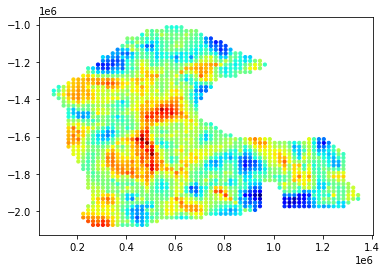

In [35]:
plt.scatter( output_data_coverage_above_80[:,1],  output_data_coverage_above_80[:,2] , 10 ,  output_data_coverage_above_80[:,4] , cmap = "jet_r")